In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report

In [3]:
df = pd.read_csv("dataset.csv")  # Change to your dataset path
df["text"] = df["text"].astype(str)

# Tokenization
tokenized_texts = [text.split() for text in df["text"]]

In [4]:
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Function to get sentence embeddings
def get_sentence_embedding(sentence, model, vector_size):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(vector_size)

In [5]:
X = np.array([get_sentence_embedding(text, w2v_model, 100) for text in df["text"]])
y = df["label"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# CLASSIFIERS

models = {
    "DECISION TREE": DecisionTreeClassifier(),
    "RANDOM FOREST": RandomForestClassifier(),
    "SVM": SVC(),
    "NAIVE BAYES": GaussianNB(),
    "LOGISTIC REGRESSION": LogisticRegression()
}
# STORING RESULTS

accuracy_results = {}
time_results = {}
conf_matrices = {}


DECISION TREE Accuracy: 0.8332
DECISION TREE Prediction Time: 0.9745 seconds

+--------------+-------------+----------+------------+-----------+
| Metric       |   Precision |   Recall |   F1-Score |   Support |
+==============+=============+==========+============+===========+
| 0            |    0.844037 | 0.822478 |   0.833118 |       783 |
+--------------+-------------+----------+------------+-----------+
| 1            |    0.822704 | 0.844241 |   0.833333 |       764 |
+--------------+-------------+----------+------------+-----------+
| macro avg    |    0.83337  | 0.833359 |   0.833226 |      1547 |
+--------------+-------------+----------+------------+-----------+
| weighted avg |    0.833501 | 0.833226 |   0.833224 |      1547 |
+--------------+-------------+----------+------------+-----------+

RANDOM FOREST Accuracy: 0.9069
RANDOM FOREST Prediction Time: 5.1762 seconds

+--------------+-------------+----------+------------+-----------+
| Metric       |   Precision |   Recal

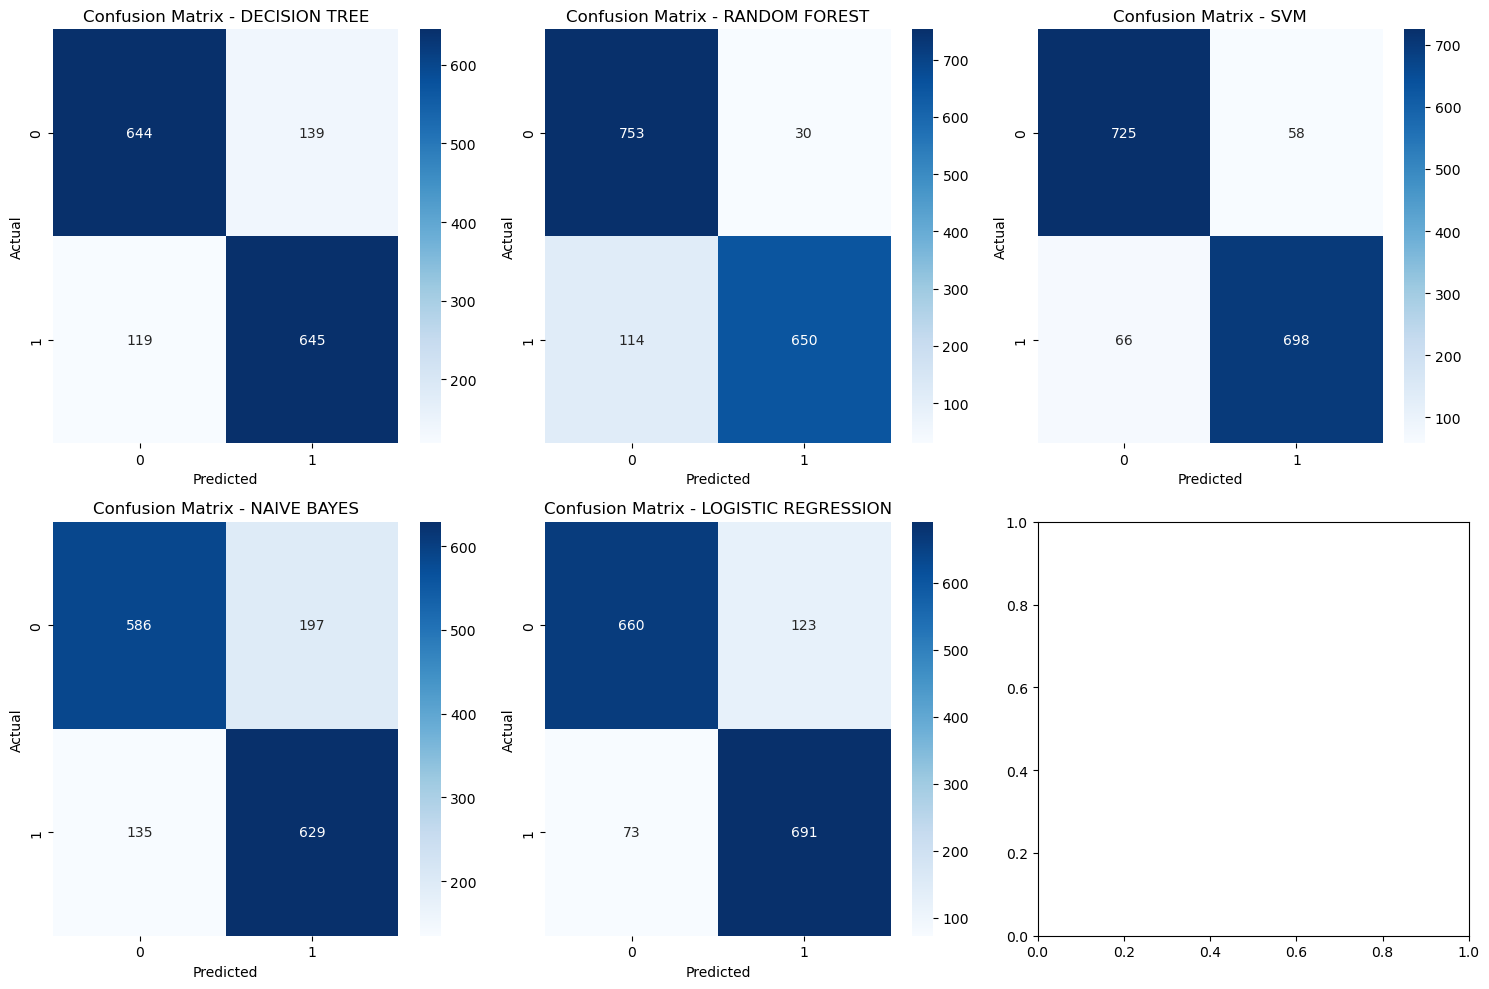

In [7]:
from tabulate import tabulate

# TRAINING AND EVALUATE

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    acc = accuracy_score(y_test, y_pred)
    accuracy_results[name] = acc
    time_results[name] = end_time - start_time
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    # Generate classification report as dictionary
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Convert report into tabulated format
    headers = ["Metric", "Precision", "Recall", "F1-Score", "Support"]
    table = []
    for label, values in report.items():
        if isinstance(values, dict):
            row = [label] + [values.get(metric, "") for metric in ["precision", "recall", "f1-score", "support"]]
            table.append(row)
    
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(f"{name} Prediction Time: {time_results[name]:.4f} seconds\n")
    
    # Print formatted classification report table
    print(tabulate(table, headers=headers, tablefmt="grid"))
    
    print("==============================================================")

# CONFUSION MATRIX

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for idx, (name, matrix) in enumerate(conf_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()


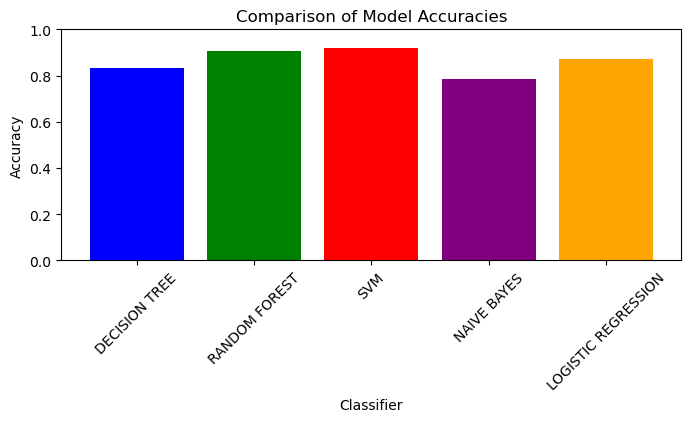

In [8]:
plt.figure(figsize=(8, 3))
plt.bar(accuracy_results.keys(), accuracy_results.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

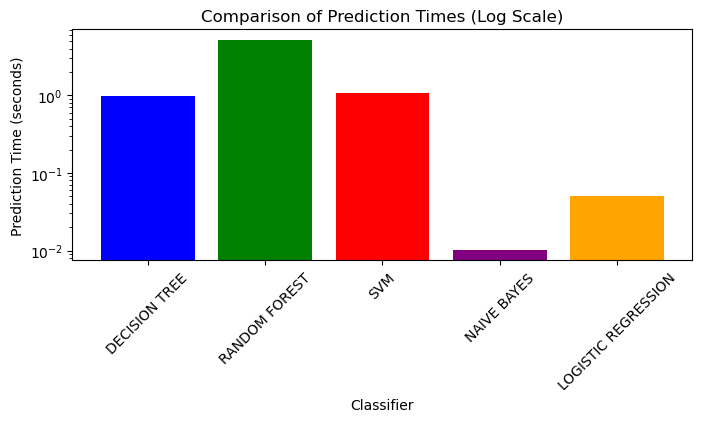


Final Results Table:

+---------------------+------------+----------+------------+-----------------------------+
| Classifier          |   Accuracy |   Recall |   F1-Score |   Prediction Time (seconds) |
+=====================+============+==========+============+=============================+
| DECISION TREE       |     0.8332 |   0.8334 |     0.8332 |                    0.974525 |
+---------------------+------------+----------+------------+-----------------------------+
| RANDOM FOREST       |     0.9069 |   0.9062 |     0.9065 |                    5.17617  |
+---------------------+------------+----------+------------+-----------------------------+
| SVM                 |     0.9198 |   0.9198 |     0.9198 |                    1.07252  |
+---------------------+------------+----------+------------+-----------------------------+
| NAIVE BAYES         |     0.7854 |   0.7859 |     0.7852 |                    0.010155 |
+---------------------+------------+----------+------------+-------

In [9]:
from tabulate import tabulate

# COMPARING RESULTS (Prediction Time Bar Chart)
plt.figure(figsize=(8, 3))
plt.bar(time_results.keys(), time_results.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Classifier")
plt.ylabel("Prediction Time (seconds)")
plt.title("Comparison of Prediction Times (Log Scale)")
plt.xticks(rotation=45)
plt.yscale("log")
plt.show()

# Collect Recall & F1-Score
recall_results = {}
f1_results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    recall_results[name] = report["macro avg"]["recall"]
    f1_results[name] = report["macro avg"]["f1-score"]

# Display results in a structured table
headers = ["Classifier", "Accuracy", "Recall", "F1-Score", "Prediction Time (seconds)"]
table = []

for name in accuracy_results.keys():
    row = [
        name, 
        f"{accuracy_results[name]:.4f}", 
        f"{recall_results[name]:.4f}", 
        f"{f1_results[name]:.4f}", 
        f"{time_results[name]:.6f}"
    ]
    table.append(row)

print("\nFinal Results Table:\n")
print(tabulate(table, headers=headers, tablefmt="grid"))


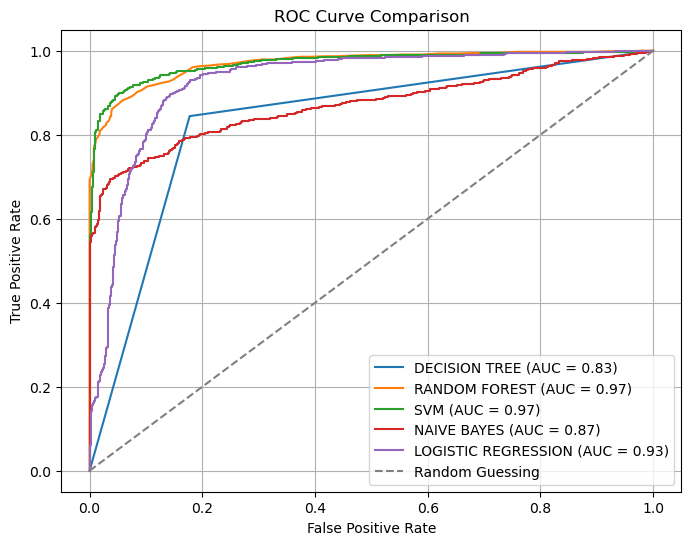

In [17]:
# R O C  CURVE


plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Get prediction probabilities (if model supports it)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    else:
        # For SVM or models that don’t support predict_proba, use decision_function
        y_proba = model.decision_function(X_test)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot baseline (random guessing)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
